# TP Coding autoencoders and variational autoencoders in Pytorch


Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST. We recall that an autoencoder is a neural network with the following general architecture:


![AUTOENCODER](https://perso.telecom-paristech.fr/anewson/doc/images/autoencoder_illustration_2.png)

The tensor $z$ in the middle of the network is called a __latent code__, and it belongs to the latent space. It is this latent space which is interesting in autoencoders (for image synthesis, editing, etc).

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)


First of all, let's load some packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import matplotlib.pyplot as plt

def pytorch_to_numpy(x):
  return x.detach().numpy()

First, we load the mnist dataset.

In [3]:

batch_size = 128

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=batch_size, shuffle=True,drop_last=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=batch_size, shuffle=True,drop_last=True)


In [4]:
mnist_trainset_reduced.dataset.train_data.shape

/home/kr0pt/Documents/Documentos/Telecom/IMA/ima_venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

# 1 Vanilla Autoencoder

Now, we define the general parameters of the autoencoder

In [5]:
# autoencoder parameters
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
n_epochs = 150

Now, define the autoencoder architecture. In the first part, we will use the following MLP architecture :

Encoder :
- Flatten input
- Dense layer, output size h_dim_1 + ReLU
- Dense layer, output size h_dim_2 + ReLU
- Dense layer, output size z_dim (no non-linearity)

Decoder :
- Dense layer, output size h_dim_2 + ReLU
- Dense layer, output size h_dim_1 + ReLU
- Dense layer, output size x_dim + Sigmoid Activation
- Reshape, to size $28\times 28\times 1$

For the Reshape operation, use the ```A.view(dim_1,dim_2,...)``` function, where ```A``` is your tensor.

In [6]:
class AE(torch.nn.Module ):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
    super(AE, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(n_pixels,h_dim1) #  # FILL IN CODE HERE
    self.fc2 = nn.Linear(h_dim1, h_dim2)  #FILL IN CODE HERE
    self.fc3 = nn.Linear(h_dim2, z_dim) # FILL IN CODE HERE
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2) # FILL IN CODE HERE
    self.fc5 = nn.Linear(h_dim2, h_dim1) # FILL IN CODE HERE
    self.fc6 = nn.Linear(h_dim1, n_pixels) # FILL IN CODE HERE

  def encoder(self, x):
    h = x.view((-1, n_pixels)) # FILL IN CODE HERE
    h = nn.ReLU()(self.fc1(h))
    h = nn.ReLU()(self.fc2(h))
    return self.fc3(h) # FILL IN CODE HERE

  def decoder(self, z):
    h = nn.ReLU()(self.fc4(z)) 
    h = nn.ReLU()(self.fc5(h))
    h = nn.Sigmoid()(self.fc6(h)) # FILL IN CODE HERE
    return h.view(-1, self.n_channels, self.n_rows, self.n_cols) # FILL IN CODE HERE

  def forward(self, x):
    y = self.decoder(self.encoder(x)) # FILL IN CODE HERE
    return(y)
  def loss_function(self,x, y):
    bce_loss = F.binary_cross_entropy(y,x, reduction='sum') # FILL IN CODE HERE
    return torch.mean(bce_loss)

In [7]:
# create model
ae_dim_1 = 512
ae_dim_2 = 256
z_dim = 10
ae_model = AE(x_dim=n_pixels, h_dim1= ae_dim_1, h_dim2=ae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
ae_optimizer = optim.Adam(ae_model.parameters())

Now, define a generic function to train the model for one epoch

In [8]:
def train_ae(ae_model,data_train_loader,epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(data_train_loader):
		ae_optimizer.zero_grad() # make sure gradients are zeroed before backpropagation
		
		y = ae_model.forward(data) # FILL IN CODE HERE
		loss_ae = ae_model.loss_function(data, y) # FILL IN CODE HERE
  
		loss_ae.backward()
		train_loss += loss_ae.item()
		ae_optimizer.step()
		
		if batch_idx % 100 == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(data_train_loader.dataset),
				100. * batch_idx / len(data_train_loader), loss_ae.item() / len(data)))
	print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


We define a function to carry out testing on the autoencoder model

In [9]:
for epoch in range(0, n_epochs):
  train_ae(ae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 543.145325
====> Epoch: 0 Average loss: 432.3980
Train Epoch: 1 [0/1000 (0%)]	Loss: 295.900757
====> Epoch: 1 Average loss: 242.9721
Train Epoch: 2 [0/1000 (0%)]	Loss: 223.918243
====> Epoch: 2 Average loss: 204.3144
Train Epoch: 3 [0/1000 (0%)]	Loss: 221.445236
====> Epoch: 3 Average loss: 192.0198
Train Epoch: 4 [0/1000 (0%)]	Loss: 218.124710
====> Epoch: 4 Average loss: 186.6747
Train Epoch: 5 [0/1000 (0%)]	Loss: 213.877686
====> Epoch: 5 Average loss: 184.3875
Train Epoch: 6 [0/1000 (0%)]	Loss: 195.590271
====> Epoch: 6 Average loss: 181.4337
Train Epoch: 7 [0/1000 (0%)]	Loss: 201.269226
====> Epoch: 7 Average loss: 180.6676
Train Epoch: 8 [0/1000 (0%)]	Loss: 202.024002
====> Epoch: 8 Average loss: 177.6190
Train Epoch: 9 [0/1000 (0%)]	Loss: 199.492584
====> Epoch: 9 Average loss: 175.4661
Train Epoch: 10 [0/1000 (0%)]	Loss: 186.675064
====> Epoch: 10 Average loss: 172.3624
Train Epoch: 11 [0/1000 (0%)]	Loss: 185.856873
====> Epoch: 11 Average los

In [10]:
def display_images(imgs):
  
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[j].imshow(pytorch_to_numpy(imgs[j, 0,:,:]), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs):
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]
  print(test_imgs.shape)

  #get output images
  output_imgs = pytorch_to_numpy(ae_model.forward( test_imgs ))
  print(output_imgs.shape)
  
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

torch.Size([5, 1, 28, 28])
(5, 1, 28, 28)


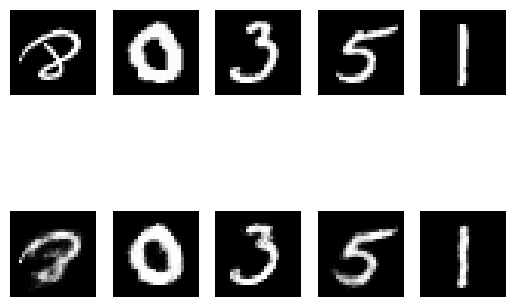

In [11]:
test_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(ae_model, test_imgs)

__Question__ Are you satisfied with the results, do they look good ?

__Answer__ They are clearly the same number, but with some blurry not being the same image.   

## 2/ Two simple generative models

In this section, we consider two naïve approaches to creating generative models. The general idea is the following:

- train an autoencoder
- estimate different statistics (average, variance) of the data in the latent space
- using these statistics, define a model based on a Gaussian distribution
- generate data with this distribution

We will consider these two situations :

- a multivariate Gaussian distribution with __diagonal covariance matrix__ (each latent component is an independent random variable). This requires the average and variance in each latent component
- a multivariate Gaussian distribution with __non-diagonal covariance matrix__. This requires the average and covariance matrix of the latent components

Obviously, since this is done _a posteriori_ after training the autoencoder, there is nothing which guarantees that the latent codes do indeed follow a Gaussian distribution. Our goal will be to verify that Variational Autoencoders indeed produce better results than such naïve approaches.

## 2.0 Defining and generating random Gaussian latent codes

Let $z$ be a latent code and $d$ the dimension of the latent space (called ``z_dim`` in the code). We suppose that the $z$'s follow a multivariate Gaussian distribution, written as:

\begin{equation}
z \sim \mathcal{N}\left(
\mu,
\bf{C}
\right),
\end{equation}
where $\mu$ and $\bf{C}$ are the average vector and covariance matrix of the Gaussian distribution. To define such a generative model, we must therefore determine $\mu$ and $\bf{C}$. Once this is done, we can generate a random Gaussian latent code in the following manner:

\begin{equation}
z = \mu + {\bf{L}} \varepsilon,
\end{equation}
where $\varepsilon$ is a random vector drawn from a multivariate normal distribution ($\mu=0$ and ${\bf{C}} = \text{Id}$), and $\bf{L}$ is the Cholesky decomposition of the positive semi-definite covariance matrix. In other words:

\begin{equation}
{\bf{C}} = {\bf{L}}{\bf{L}^T}.
\end{equation}

This gives a simple method of producing a multivariate Gaussian random variable.

## 2.1/ A Gaussian model with diagonal covariance

The first naïve model is  defined in this first case as:

- $\bf{\mu}=\left[\mu_0, \mu_1, \cdots, \mu_{d-1}\right]^T$
- $
  \bf{C} = \begin{pmatrix}
\sigma_0^2 & 0 & \cdots & 0 \\
0 & \sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}^2
\end{pmatrix}$

In this situation, therefore, the matrix $\bf{L}$ can be calculated quite simply, as:
- $
  \bf{L} = \begin{pmatrix}
\sigma_0 & 0 & \cdots & 0 \\
0 & \sigma_1 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}
\end{pmatrix}$

In the next cell, calculate the empirical average and variances over a certain number of batches:

In [54]:
n_batches = np.floor( len(mnist_train_loader.dataset.indices)/batch_size ).astype(int)

z_average = torch.zeros(n_batches,ae_model.z_dim) #(7,10)
z_sigma = torch.zeros(n_batches,ae_model.z_dim) #(7,10)

for batch_idx, (data, _) in enumerate(mnist_train_loader):
  z = ae_model.encoder(data)
  z_average[batch_idx,:] = torch.mean(z, dim=0) # FILL IN CODE HERE
  z_sigma[batch_idx,:] = torch.std(z, dim=0) # FILL IN CODE HERE


z_average = torch.mean(z_average) # FILL IN CODE HERE
z_sigma = torch.mean(z_sigma) # FILL IN CODE HERE

print("Average of latent codes:", z_average)
print("Standard deviation of latent codes:",z_sigma)

Average of latent codes: tensor(-1.3214, grad_fn=<MeanBackward0>)
Standard deviation of latent codes: tensor(7.5679, grad_fn=<MeanBackward0>)


Now, in the next cell generate data with this simple generative model using the approach described above. Display these images with the ``display_images`` function. 

__NB__ You do not actually have to define the matrix $\bf{L}$ in this case, an element-wise multiplication of two (properly chosen) vectors will suffice. To generate multivariate normal random variables you can use the following Pytorch function:

- ```torch.randn```


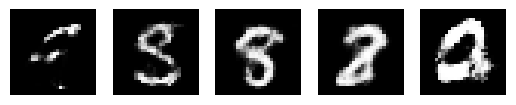

In [316]:
def generate_images_diagonal_gaussian(ae_model,z_average,z_sigma, n_images = 5):

  epsilon = torch.randn(size=(n_images,ae_model.z_dim)) # FILL IN CODE HERE
  z_generated = z_average + torch.mul(epsilon, z_sigma)  # FILL IN CODE HERE
  imgs_generated = ae_model.decoder(z_generated) # FILL IN CODE HERE
  return(imgs_generated)

imgs_generated = generate_images_diagonal_gaussian(ae_model,z_average,z_sigma, n_images=5)
display_images(imgs_generated)

As you should be able to see, these results are not that good. Let's try a slightly more sophisticated model.

## 2.1 Non-diagonal Gaussian model

The second model uses a non-diagonal covariance matrix $\bf{C}$ in the multivariate Gaussian distribution. In the next cell, calculate the average and covariance matrix over several batches of latent codes.

__NB__ You can use the ```torch.cov``` function. Make sure to put the data in the right format for this (see documentation : https://pytorch.org/docs/stable/generated/torch.cov.html).

In [59]:
n_batches = np.floor( len(mnist_train_loader.dataset.indices)/batch_size).astype(int)

z_average = torch.zeros(n_batches,ae_model.z_dim) #(7,10)
z_covariance = torch.zeros(n_batches,ae_model.z_dim,ae_model.z_dim) #(7,10,10)

for batch_idx, (data, _) in enumerate(mnist_train_loader):
  z = ae_model.encoder(data)
  z_average[batch_idx,:] = torch.mean(z, dim=0) # FILL IN CODE HERE
  # we transpose z because cov expects features in rows and observations in columns
  z_covariance[batch_idx,:,:] = torch.cov(z.T) # FILL IN CODE HERE  

z_average = torch.mean(z_average, dim=0) # FILL IN CODE HERE
z_covariance = torch.mean(z_covariance, dim=0) # FILL IN CODE HERE

print("Average of latent codes:", z_average)
print("Covariance matrix of latent codes:\n", z_covariance)

Average of latent codes: tensor([ -4.3167,   0.0579,   5.4114,  -5.2670,  -9.1830,   9.6678,   8.8234,
          2.5784,  -8.5171, -12.1526], grad_fn=<MeanBackward1>)
Covariance matrix of latent codes:
 tensor([[ 5.8899e+01, -1.0913e+01, -1.0074e+01, -2.3460e+00, -2.0314e+01,
          1.6146e+01, -1.5793e+01,  6.1212e-03,  3.7768e+00,  6.8864e+00],
        [-1.0913e+01,  9.1700e+01,  3.1203e+00,  3.8034e+00, -1.5285e+01,
          1.4385e+01,  2.2418e+00, -1.3819e+00, -3.4224e+00, -2.9534e+01],
        [-1.0074e+01,  3.1203e+00,  2.8858e+01,  1.1921e+01, -1.0325e+01,
         -9.8333e+00,  1.9444e+01, -1.1486e+01, -1.4103e+01, -1.5266e+01],
        [-2.3460e+00,  3.8034e+00,  1.1921e+01,  7.1889e+01, -1.5045e+01,
          5.6800e+00,  8.4520e+00, -4.3913e+00, -7.4770e+00, -1.5719e+01],
        [-2.0314e+01, -1.5285e+01, -1.0325e+01, -1.5045e+01,  6.0286e+01,
         -8.4625e+00, -2.2172e+01, -2.4250e+00,  2.5011e+01,  2.2479e+01],
        [ 1.6146e+01,  1.4385e+01, -9.8333e+00,  5.6

Now, generate some samples with this distribution. In this case, you will actually have to calculate the Cholesky decomposition and find $\bf{L}$. For this, you can use 

- ```torch.linalg.cholesky```

In this model, you will need to carry out matrix multiplication over a batch of latent codes, which is a bit more complicated than the previous naïve model (which used element-wise vector multiplication). So you have two options:

- copy the matrix $\bf{L}$ several times and carry out batch matrix multiplication
- simply loop and carry out normal matrix multiplication to produce each image (this has the disadvantage of not taking advantage of any parallelisation, but it should not matter too much).

In the first case, you can use the following functions:

- ```torch.bmm```
- ```torch.tile```

Fill in the function to generate images using this model now:

In [324]:
def generate_images_non_diagonal_gaussian(ae_model, z_average, z_covariance, n_images=5):

    # Calculate Cholesky decomposition of covariance matrix: C = L L^T
    # Make sure that the first dimension is the batch dimension (with batch size n_images)
    # You can use the torch.unsqueeze function for this
    L = torch.linalg.cholesky(z_covariance) # (z_dim, z_dim)
    L = torch.unsqueeze(L, dim=0) # add a dimension at the beginning (1, z_dim, z_dim)
    L = torch.tile(L, (n_images,1,1)) # repeat L n_images times along the first dimension (n_images, z_dim, z_dim)

    epsilon = torch.randn(n_images, ae_model.z_dim)  # create a tensor with random values (n_images, z_dim)
    epsilon = torch.unsqueeze(epsilon, dim=2) # add a dimension at the end (n_images, z_dim, 1) to be able to multiply with L
    batch_mm = torch.bmm(L, epsilon) # multiply L with epsilon (n_images, z_dim, 1)
    batch_mm = torch.squeeze(batch_mm, dim=2) # remove the last dimension (n_images, z_dim)
    z_generated = z_average + batch_mm  # generate z values (n_images, z_dim)
    imgs_generated = ae_model.decoder(z_generated)  # generate images (n_images, n_channels, n_rows, n_cols)
    return (imgs_generated)

torch.Size([5, 1, 28, 28])


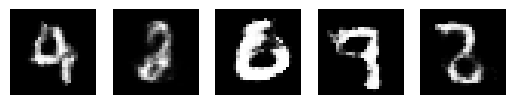

In [287]:
imgs_generated = generate_images_non_diagonal_gaussian(ae_model, z_average, z_covariance, n_images=5)
display_images(imgs_generated)

You should see some improvement, but we can do better than this. Thus, we turn to the variational autoencoder.

# 3/ Variational autoencoder

Now, we are going to create an variational autoencoder to carry out __image generation__. Let's first recall the idea of a variational autoencoder

## Main idea

The main idea is to create an autoencoder whose latent codes follow a certain distribution (a Gaussian distribution in practice). This is done with two tools : 

- A specific architecture, where the encoder produces the average and variance of the latent codes
- A specially designed loss function

Once the VAE is trained, it is possible to sample in the latent space by producing random normal variables and simply decoding.

## Architecture

The architecture of the VAE model is as follows:

The encoder consists of:

Encoder :
- Flatten input
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer (no non-linarity) to produce the average, Dense layer (no non-linarity) to produce the variance (these last two layers are in parallel)

Decoder :
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer $+$ Sigmoid Activation
- Reshape, to size $28\times 28\times 1$


## Variational Autoencoder loss

Recall that for the VAE, the loss function is in fact a function to __maximise__. In fact, for implementation, you will see that it is easier to __minimise__ $-\mathcal{L}$.

In the case of an image which is represented by a set of __Bernoulli__ variables (which is relevant for mnist), the original loss function (to maximise) is written :


\begin{align}
\mathcal{L} &= \log\left(p_\theta(x|z)\right) - KL\left( q_\phi(z|x) \; || \; p_\theta(z)\right) \\
    &= \left(\sum_{i} x_i \log y_i + (1-x_i) \log (1-y_i)\right) - \left(\frac{1}{2} \sum_j \left( \sigma_j^2 + \mu_j^2 - \log \sigma_j^2 -1 \right)\right)
\end{align}


where $i$ is summed over the image pixels, and $j$ is summed over the elements of the latent space. $\sigma_j^2$ is the $j \text{th}$ element of the latent space variance, and $\mu_j$ is the $j \text{th} $ element of the latent space mean.

The left part of the loss (reconstruction error) can be implemented simply as the binary cross-entropy between the input x and the output y. Since we are __maximising__ $-$[binary cross-entropy] (look at the formula), this is equivalent to minimising the binary cross-entropy.

For the right part of the equation (KL divergence), you need to implement it manually. 

The final loss is the average, over the batch size, of the sum of the reconstruction error (left part) and the KL divergence (right part). Be careful, in the formula, the sums over $i$ and $j$ are over the number of pixels and the number of latent elements, respectively. To achieve a sum rather than an average, you can use ```torch.nn.BCELoss(reduction='sum')()```, and the ```torch.sum()``` functions.

As in the case of the normal autoencoder, you will need to flatten and then reshape the tensors at the beginning/end of the network.

In [202]:
class VAE(torch.nn.Module ):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
    super(VAE, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(n_pixels,h_dim1) # FILL IN CODE HERE
    self.fc2 = nn.Linear(h_dim1, h_dim2) # FILL IN CODE HERE
    self.fc31 = nn.Linear(h_dim2, z_dim) # FILL IN CODE HERE
    self.fc32 = nn.Linear(h_dim2, z_dim) # FILL IN CODE HERE
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2) # FILL IN CODE HERE
    self.fc5 = nn.Linear(h_dim2, h_dim1) # FILL IN CODE HERE
    self.fc6 = nn.Linear(h_dim1, n_pixels) # FILL IN CODE HERE

  def encoder(self, x):
    h = x.view((-1, n_pixels))# FILL IN CODE HERE
    h = nn.ReLU()(self.fc1(h))
    h = nn.ReLU()(self.fc2(h))
    return self.fc31(h), self.fc32(h)  # FILL IN CODE HERE # mu, log_var
  
  def decoder(self, z):
    h = nn.ReLU()(self.fc4(z)) # FILL IN CODE HERE
    h = nn.ReLU()(self.fc5(h)) # FILL IN CODE HERE
    h = nn.Sigmoid()(self.fc6(h))
    return h.view(-1, self.n_channels, self.n_rows, self.n_cols) # FILL IN CODE HERE

  def sampling(self, mu, log_var):
    # this function samples a Gaussian distribution, with average (mu) and standard deviation specified (using log_var)
    std = torch.exp(0.5*log_var) # FILL IN CODE HERE
    eps = torch.randn_like(std) # FILL IN CODE HERE
    return eps.mul(std).add_(mu) # return z sample

  def forward(self, x):
    z_mu, z_log_var = self.encoder(x.view(-1, n_channels * n_rows * n_cols))
    z = self.sampling(z_mu, z_log_var)
    return self.decoder(z),z_mu, z_log_var

  def loss_function(self,x, y, mu, log_var):
    reconstruction_error = torch.nn.BCELoss(reduction='sum')(y, x) # FILL IN CODE HERE
    var = torch.exp(log_var)
    # KLD = -0.5 * torch.sum(var + mu.pow(2) - log_var -1) # FILL IN CODE HERE
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
    return (reconstruction_error + KLD) / x.shape[0] # FILL IN CODE HERE

Now, create the model (similarly as above)

In [203]:
# create model
vae_dim_1 = ae_dim_1
vae_dim_2 = ae_dim_2
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
vae_optimizer = optim.Adam(vae_model.parameters())

Finally, train the model. First modify the training function to the case of the vae.

In [204]:
def train_vae(vae_model,data_train_loader,epoch):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(data_train_loader):
    vae_optimizer.zero_grad()
    y, z_mu, z_log_var = vae_model.forward(data) # FILL IN CODE HERE
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var) # FILL IN CODE HERE
    loss_vae.backward()
    train_loss += loss_vae.item()
    vae_optimizer.step() 
		
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_train_loader.dataset),
      100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


In [205]:
# now train the model
for epoch in range(0, n_epochs):
  train_vae(vae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 4.251554
====> Epoch: 0 Average loss: 3.1876
Train Epoch: 1 [0/1000 (0%)]	Loss: 2.324847
====> Epoch: 1 Average loss: 1.8053
Train Epoch: 2 [0/1000 (0%)]	Loss: 1.706882
====> Epoch: 2 Average loss: 1.5449
Train Epoch: 3 [0/1000 (0%)]	Loss: 1.683490
====> Epoch: 3 Average loss: 1.4869
Train Epoch: 4 [0/1000 (0%)]	Loss: 1.736177
====> Epoch: 4 Average loss: 1.4710
Train Epoch: 5 [0/1000 (0%)]	Loss: 1.654934
====> Epoch: 5 Average loss: 1.4533
Train Epoch: 6 [0/1000 (0%)]	Loss: 1.611015
====> Epoch: 6 Average loss: 1.4435
Train Epoch: 7 [0/1000 (0%)]	Loss: 1.577133
====> Epoch: 7 Average loss: 1.4380
Train Epoch: 8 [0/1000 (0%)]	Loss: 1.584444
====> Epoch: 8 Average loss: 1.4248
Train Epoch: 9 [0/1000 (0%)]	Loss: 1.593822
====> Epoch: 9 Average loss: 1.4111
Train Epoch: 10 [0/1000 (0%)]	Loss: 1.531602
====> Epoch: 10 Average loss: 1.4011
Train Epoch: 11 [0/1000 (0%)]	Loss: 1.547298
====> Epoch: 11 Average loss: 1.3952
Train Epoch: 12 [0/1000 (0%)]	Loss: 

Now, generate some images with the VAE model

In [ ]:
def generate_images_vae(vae_model,n_images = 5):

  epsilon = torch.randn(n_images, vae_model.z_dim) # FILL IN CODE HERE
  imgs_generated = vae_model.decoder(epsilon) # FILL IN CODE HERE
  return(imgs_generated)

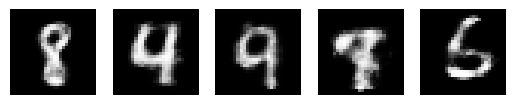

In [327]:
imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)

Do you think the results are better ? What difference can you see ? What advantage does the Variational Autoencoder have over the simple autoencoder model, even though the second autoencoder approach has a more complex probabilistic latent model (a full covariance matrix) ?

__Answer__ The results are better. Compared to the AE outputs, the VAE outputs are more blurry, but the numbers created seems to be closer to the numbers in the dataset. Also, some outputs from VAE sometimes seems to be the mixture of two numbers, while there are outputs from AE that are not understandable.  

We will now compare the models quantitavely.

# 3 Evaluating and comparing the models

We will evaluate the models, in the following manner:

- we train a simple convolutional neural network classifier on mnist, to a good accuracy
- we generate images with each model
- we find the average of the highest probability of the images according to the classifier, for each model. If this value is high, it means that on average the classifier considers that the images look like a 

We will use the following convoluional architecture for the classifier:

- conv2d, filter size  3×3 , 32 filters, stride=(1,1), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(1,1), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

Now, define the model. To make things easier, use the ```torch.nn.Sequential``` API (there is no need for a Class in this simple case).

In [311]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(14*14*n_h_2, nb_classes),
) # FILL IN CODE HERE

criterion = nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

Create a function to calculate accuracy, instead of loss

In [312]:
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

Now, train the model. You should be able to achieve an accuracy close to 1.00 within 20 epochs

In [313]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0062 Accuracy:0.7578
Epoch:1 Train Loss:0.0052 Accuracy:0.8359
Epoch:2 Train Loss:0.0037 Accuracy:0.8516
Epoch:3 Train Loss:0.0021 Accuracy:0.9141
Epoch:4 Train Loss:0.0014 Accuracy:0.9375
Epoch:5 Train Loss:0.0015 Accuracy:0.9453
Epoch:6 Train Loss:0.0008 Accuracy:0.9531
Epoch:7 Train Loss:0.0007 Accuracy:0.9609
Epoch:8 Train Loss:0.0004 Accuracy:0.9922
Epoch:9 Train Loss:0.0001 Accuracy:1.0000
Epoch:10 Train Loss:0.0001 Accuracy:1.0000
Epoch:11 Train Loss:0.0000 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### Evaluate the average maximum prediction of the images generated by each generative model (higher is better)

Now, we will evaluate the models. For each ones, produce a certain number of images, and put those images through the classification network. Then find the maximum class probability of each image, and average it over all the images. We will use this as a metric to evaluate each model.

__CAREFUL__: the output of the network does __not__ include the Softmax layer, so you will have to carry it out, with:
- ```torch.nn.Softmax()(...)```

Define this metric now:

In [318]:
def generative_model_score(imgs_in,classification_model):
  # calculate the class probability for each image
  softmax_values = F.softmax(classification_model(imgs_in), dim=1)
  # take the maximum class probability for each image
  maximum_class_prob = torch.max(softmax_values, dim=1).values 
  # calculate the generative score as the mean of the maximum class probabilities
  gen_score = torch.mean(maximum_class_prob)
  return(gen_score)

Now, generate some images with each of the three models, and evaluate these models:

In [325]:
imgs_diagonal_gaussian = generate_images_diagonal_gaussian(ae_model,z_average,z_sigma,n_images = 50)
imgs_non_diagonal_gaussian = generate_images_non_diagonal_gaussian(ae_model,z_average,z_covariance,n_images = 50)
imgs_vae = generate_images_vae(vae_model,n_images=50)

# average of maximum of first model 
diagonal_gaussian_score = float(generative_model_score(imgs_diagonal_gaussian,mnist_classification_model))
non_diagonal_gaussian_score = float(generative_model_score(imgs_non_diagonal_gaussian,mnist_classification_model))
vae_gaussian_score = float(generative_model_score(imgs_vae,mnist_classification_model))

print("Diagonal gaussian generative model score : ",diagonal_gaussian_score)
print("Non diagonal gaussian generative model score : ",non_diagonal_gaussian_score)
print("Variational autoencoder model score: ",vae_gaussian_score) 

Diagonal gaussian generative model score :  0.8103694319725037
Non diagonal gaussian generative model score :  0.9129528999328613
Variational autoencoder model score:  0.9188739061355591


Please answer the following questions:

- Which model is better quantitatively ? 
    - The variational autoencoder model.
- Do the quantitative result support the qualitative results ?
    - The quantitative the difference between the non diagonal gaussian generative model is lower in comparison to the qualitative difference.
- Can you see any drawbacks of this method of evaluation ?
    - This metric is vulnerable to overconfident predictions by the classification model. If the classification model assigns high probabilities to certain classes, even if the generated images are not very realistic, the metric could be biased and overestimate the performance of the generative model. In addition, the generative model may only produce a limited set of highly recognizable images, while failing to generate other types of images that are present in the real data, which is not captured by this method of evaluation.
- Can you propose any more sophisticated models than the multivariate Gaussian approach (apart from the variational autoencoder) ?
    - GAN (Generative Adversarial Networks) is one example of more sophisticated models that can be used for image generation. It consist of a generator network that learns to produce synthetic images that are similar to real images, and a discriminator network that tries to distinguish between real and fake images. The two networks are trained together in an adversarial manner, where the generator tries to produce more realistic images to fool the discriminator, while the discriminator tries to correctly identify the real images.